# Null hypothesis: No statistical difference between the ratings of folk and metal genres.

In [79]:
import pandas as pd
import numpy as np
import sklearn as sk
import scipy.stats
import psycopg2
import sqlalchemy
import pandas.io.sql as psql
import seaborn as sns
import matplotlib.pyplot as plt


%matplotlib inline

In [7]:
# create a connection to the database
# conn = psycopg2.connect("dbname=pitchfork")

In [42]:
"""Connect to database"""
conn = psycopg2.connect("dbname=pitchfork_db2")

In [43]:
cur = conn.cursor()

In [10]:
query = """SELECT table_name
FROM information_schema.tables
WHERE table_type='BASE TABLE'
AND table_schema='public';"""

In [11]:
cur.execute(query)

In [12]:
cur.fetchall()

[('reviews',),
 ('genres',),
 ('labels',),
 ('years',),
 ('content',),
 ('artists',)]

In [13]:
"""Create artists dataframe"""
df_artists = psql.read_sql("SELECT * FROM artists;", conn)
df_artists.head()

,reviewid,artist,id
0,22703,massive attack,1
1,22721,krallice,2
2,22659,uranium club,3
3,22661,kleenex,4
4,22661,liliput,5


In [14]:
"""Create content dataframe"""
df_content = psql.read_sql("SELECT * FROM content;", conn)
df_content.head()

,reviewid,content
0,22703,"“Trip-hop” eventually became a ’90s punchline,..."
1,22721,"Eight years, five albums, and two EPs in, the ..."
2,22659,Minneapolis’ Uranium Club seem to revel in bei...
3,22661,Kleenex began with a crash. It transpired one ...
4,22725,It is impossible to consider a given release b...


In [15]:
"""Create genres dataframe"""
df_genres = psql.read_sql("SELECT * FROM genres;", conn)
df_genres.head()

,reviewid,genre
0,22703,electronic
1,22721,metal
2,22659,rock
3,22661,rock
4,22725,electronic


In [16]:
"""Create labels dataframe"""
df_labels = psql.read_sql("SELECT * FROM labels;", conn)
df_labels.head()

,reviewid,label
0,22703,virgin
1,22721,hathenter
2,22659,static shock
3,22659,fashionable idiots
4,22661,kill rock stars


In [54]:
"""Create reviews dataframe"""
df_reviews = psql.read_sql("SELECT * FROM reviews;", conn)
df_reviews.head()

,reviewid,title,artist,url,score,best_new_music,author,author_type,pub_date,pub_weekday,pub_day,pub_month,pub_year
0,22703,mezzanine,massive attack,http://pitchfork.com/reviews/albums/22703-mezz...,9.3,0,nate patrin,contributor,2017-01-08,6,8,1,2017
1,22721,prelapsarian,krallice,http://pitchfork.com/reviews/albums/22721-prel...,7.9,0,zoe camp,contributor,2017-01-07,5,7,1,2017
2,22659,all of them naturals,uranium club,http://pitchfork.com/reviews/albums/22659-all-...,7.3,0,david glickman,contributor,2017-01-07,5,7,1,2017
3,22661,first songs,"kleenex, liliput",http://pitchfork.com/reviews/albums/22661-firs...,9.0,1,jenn pelly,associate reviews editor,2017-01-06,4,6,1,2017
4,22725,new start,taso,http://pitchfork.com/reviews/albums/22725-new-...,8.1,0,kevin lozano,tracks coordinator,2017-01-06,4,6,1,2017


In [35]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18393 entries, 0 to 18392
Data columns (total 13 columns):
reviewid          18393 non-null int64
title             18393 non-null object
artist            18393 non-null object
url               18393 non-null object
score             18393 non-null float64
best_new_music    18393 non-null int64
author            18393 non-null object
author_type       14487 non-null object
pub_date          18393 non-null object
pub_weekday       18393 non-null int64
pub_day           18393 non-null int64
pub_month         18393 non-null int64
pub_year          18393 non-null int64
dtypes: float64(1), int64(6), object(6)
memory usage: 1.8+ MB


In [18]:
"""Create years dataframe"""
df_years = psql.read_sql("SELECT * FROM years", conn)
df_years.head()

,reviewid,year
0,22703,1998.0
1,22721,2016.0
2,22659,2016.0
3,22661,2016.0
4,22725,2016.0


In [23]:
pd.unique(df_reviews.score)

array([ 9.3,  7.9,  7.3,  9. ,  8.1,  7.4,  7.1,  7. ,  7.7,  5.3,  8. ,
        8.6,  7.6,  3.5,  6.6,  7.2,  7.5,  6.3,  7.8,  6.5,  6.8,  8.2,
        4.4,  6.7,  5. ,  6.4,  5.9,  4.5,  8.8,  4.8,  8.4,  9.5,  8.3,
        6.9,  5.2,  8.5,  8.7,  6.2,  5.4,  6. , 10. ,  4. ,  4.9,  6.1,
        5.7,  5.1,  5.8,  5.5,  9.2,  9.4,  8.9,  9.1,  4.6,  2. ,  5.6,
        2.5,  4.7,  3.8,  3. ,  3.9,  3.2,  4.3,  4.2,  3.3,  2.4,  4.1,
        9.6,  3.6,  1. ,  3.1,  3.4,  2.8,  2.9,  2.6,  1.8,  1.6,  2.2,
        3.7,  2.1,  2.7,  1.5,  9.8,  1.9,  2.3,  9.7,  1.7,  1.4,  0.2,
        0.4,  1.3,  0. ,  9.9,  0.6,  0.5,  1.2,  0.9,  0.8,  1.1,  0.7,
        0.1,  0.3])

In [51]:
mean_review = df_reviews.score.mean()
mean_review

7.00577937258735

In [56]:
sd_mean = df_reviews.score.std()
sd_mean

1.2936745021540692

In [44]:
"""dataframe of genres and scores"""
cur.execute("""SELECT score, genre FROM reviews 
            JOIN genres 
            ON reviews.reviewid = genres.reviewid
            ;""")
df_genre_scores = pd.DataFrame(cur.fetchall())
df_genre_scores.columns = [i[0] for i in cur.description]

In [45]:
df_genre_scores.head()

,score,genre
0,9.3,electronic
1,7.9,metal
2,7.3,rock
3,9.0,rock
4,8.1,electronic


In [71]:
df_genre_scores.genre.value_counts()

rock            9438
electronic      3874
experimental    1815
rap             1559
pop/r&b         1432
metal            862
folk/country     685
jazz             435
global           219
Name: genre, dtype: int64

In [61]:
df_genre_scores.groupby('genre')['score'].mean()

genre
electronic      6.920702
experimental    7.336694
folk/country    7.202190
global          7.429680
jazz            7.303908
metal           6.950000
pop/r&b         6.883799
rap             6.900513
rock            6.942011
Name: score, dtype: float64

In [72]:
mu_metal_score = 6.95
mu_folk_score = 7.20219

In [62]:
df_genre_scores.groupby('genre')['score'].std()

genre
electronic      1.310056
experimental    1.106455
folk/country    1.064435
global          1.006076
jazz            1.251104
metal           1.387799
pop/r&b         1.295232
rap             1.302703
rock            1.360347
Name: score, dtype: float64

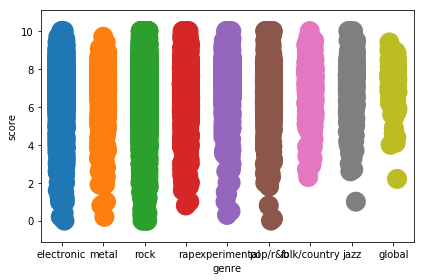

In [63]:
sns.stripplot(x="genre", y="score", data=df_genre_scores, size = 20)
plt.tight_layout()

In [69]:
df_genre_scores.describe()

,score
count,22690.000000
mean,6.991155
std,1.305532
min,0.000000
25%,6.400000
50%,7.200000
75%,7.800000
max,10.000000


In [77]:
is_folk = df_genre_scores['genre']== 'folk/country'
folk_scores = df_genre_scores.loc[is_folk]
folk_scores.head()

,score,genre
28,6.8,folk/country
78,7.8,folk/country
127,7.3,folk/country
147,8.5,folk/country
152,7.8,folk/country


In [78]:
is_metal = df_genre_scores['genre']== 'metal'
metal_scores = df_genre_scores.loc[is_metal]
metal_scores.head()

,score,genre
1,7.9,metal
22,7.5,metal
33,7.7,metal
124,6.5,metal
146,6.4,metal


In [83]:
scipy.stats.ttest_ind(folk_scores['score'], metal_scores['score'], axis=0, equal_var=False)

Ttest_indResult(statistic=4.044303101957469, pvalue=5.507059645103283e-05)

The p-value for this relationship is much higher than .05, so we reject the alternative hypothesis.